<a href="https://colab.research.google.com/github/joseamaya/langraph-tutorials/blob/main/RecomendadorPizzas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [35]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import START, END, StateGraph, MessagesState

model = ChatOpenAI(model="gpt-4o")

prompt_template = ChatPromptTemplate.from_messages([
    ("system", """
    Eres un psicólogo de pizzas. Clasifica el estado de ánimo del usuario en una palabra:
    - "feliz": si expresa alegría, logros o entusiasmo.
    - "triste": si menciona tristeza, estrés o decepción.
    - "aventurero": si usa palabras como "probemos algo nuevo" o "sorpréndeme".
    - "confundido": en cualquier otro caso.
    Respuesta SOLO con una de las opciones anteriores, nada más.
    """),
    ("human", "Mensaje del usuario: {user_message}")
])

mood_chain = prompt_template | model | StrOutputParser()

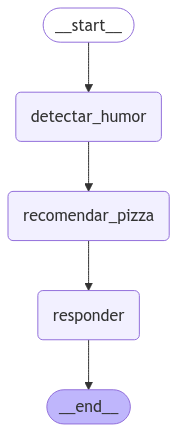

In [36]:
from IPython.display import Image, display

class PizzaState(MessagesState):
    user_message: str
    mood: str
    pizza: str

def detectar_humor(state: PizzaState):
    mood = mood_chain.invoke({"user_message": state.get('user_message')})
    return {"mood": mood.lower().strip()}

def recomendar_pizza(state: PizzaState):
    mood = state.get('mood')
    if mood == "feliz":
        return {"pizza": "Hawaiana (sí, con piña 🍍, ¡atrévete a odiarme!)"}
    elif mood == "triste":
        return {"pizza": "4 Quesos + KitKat de postre (porque el azúcar cura todo)"}
    elif mood == "aventurero":
        return {"pizza": "Picante Infernal 🌶️... ¡con jalapeños extra!"}
    else:
        return {"pizza": "Margarita Clásica (lo seguro es mejor 😉)"}

def responder_usuario(state: PizzaState):
    return {"response": f"¡Te recomiendo: {state.get('pizza')}!"}

workflow = StateGraph(PizzaState)
workflow.add_node("detectar_humor", detectar_humor)
workflow.add_node("recomendar_pizza", recomendar_pizza)
workflow.add_node("responder", responder_usuario)
workflow.add_edge(START, "detectar_humor")
workflow.add_edge("detectar_humor", "recomendar_pizza")
workflow.add_edge("recomendar_pizza", "responder")
workflow.add_edge("responder", END)
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
resultado = graph.invoke({"user_message": "Hoy quiero viajar"})
print(resultado.get('mood'))
print(resultado.get('pizza'))

aventurero
Picante Infernal 🌶️... ¡con jalapeños extra!
